# Potential Organ Donor Identifier

# Setup

In [1]:
import sys 
import os
import polars as pl 
import matplotlib.pyplot as plt
import pandas as pd

from utils.config import config
from utils.io import read_data
from utils.strobe_diagram import create_consort_diagram
from clifpy.utils.stitching_encounters import stitch_encounters
from utils.outlier_handler import apply_outlier_handling
import gc

Loaded configuration from config.json


In [2]:
site_name = config['site_name']
tables_path = config['tables_path']
file_type = config['file_type']
project_root = config['project_root']
sys.path.insert(0, project_root)
print(f"Site Name: {site_name}")
print(f"Tables Path: {tables_path}")
print(f"File Type: {file_type}")

Site Name: ucmc
Tables Path: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/2.1.0
File Type: parquet


In [3]:
strobe_counts = {}

# Load data

In [4]:
# read required tables
adt_filepath = f"{tables_path}/clif_adt.{file_type}"
hospitalization_filepath = f"{tables_path}/clif_hospitalization.{file_type}"
patient_filepath = f"{tables_path}/clif_patient.{file_type}"
adt_df = read_data(adt_filepath, file_type)
hospitalization_df = read_data(hospitalization_filepath, file_type)
patient_df = read_data(patient_filepath, file_type)

File name: clif_adt.parquet
Time taken to load the dataset: 0.03 seconds
Size of the loaded dataset: 25.00 MB

File name: clif_hospitalization.parquet
Time taken to load the dataset: 0.03 seconds
Size of the loaded dataset: 35.41 MB

File name: clif_patient.parquet
Time taken to load the dataset: 0.01 seconds
Size of the loaded dataset: 12.01 MB



# Stitch encounters

In [5]:
# Check if hospitalization_df has duplicate patient_id, hospitalization_id pairs
if hospitalization_df.shape[0] != hospitalization_df.unique(subset=["patient_id", "hospitalization_id"]).shape[0]:
    print("Warning: hospitalization_df contains duplicate (patient_id, hospitalization_id) rows.")

# Check if adt_df has duplicate patient_id, hospitalization_id, adt_event_id (or similar) triplets
# If adt_df has an event or unique identifier column, replace 'adt_event_id' with correct column
adt_unique_cols = [col for col in [ "hospitalization_id", "in_dttm"] if col in adt_df.columns]
if len(adt_unique_cols) >= 2 and adt_df.shape[0] != adt_df.unique(subset=adt_unique_cols).shape[0]:
    print("Warning: adt_df contains duplicate rows for identifier columns:", adt_unique_cols)

In [6]:
hosp_stitched, adt_stitched, encounter_mapping = stitch_encounters(
      hospitalization=hospitalization_df.to_pandas(),
      adt=adt_df.to_pandas(),
      time_interval=12
  )

hosp_stitched = pl.from_pandas(hosp_stitched)
adt_stitched = pl.from_pandas(adt_stitched)

# Ensure encounter_block is int32 (if present)
hosp_stitched = hosp_stitched.with_columns(
    pl.col("encounter_block").cast(pl.Int32)
)
adt_stitched = adt_stitched.with_columns(
    pl.col("encounter_block").cast(pl.Int32)
)

# Filter hosp_stitched to only hospitalizations that are present in the adt_stitched table
# assuming 'hospitalization_id' is the matching key
# (if there are multiple relevant keys, adjust accordingly)
if "hospitalization_id" in hosp_stitched.columns and "hospitalization_id" in adt_stitched.columns:
    hosp_stitched = (
        hosp_stitched.filter(
            pl.col("hospitalization_id").is_in(adt_stitched["hospitalization_id"].unique())
        )
    )
encounter_mapping = pl.from_pandas(encounter_mapping)
encounter_mapping = encounter_mapping.with_columns(
    pl.col("encounter_block").cast(pl.Int32)
)
total_patients = hosp_stitched["patient_id"].n_unique()
strobe_counts["0_all_patients"] = total_patients
gc.collect()
strobe_counts


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_14861/1971388393.py:23: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  hosp_stitched.filter(


{'0_all_patients': 97204}

# Identify decedents

In [7]:
patient_df.columns

['patient_id',
 'race_name',
 'race_category',
 'ethnicity_name',
 'ethnicity_category',
 'sex_name',
 'sex_category',
 'birth_date',
 'death_dttm',
 'language_name',
 'language_category']

In [8]:
# Step 1: Get the admission dates for expired and hospice discharges

# Identify expired encounters
decedents_df = hosp_stitched.filter(
    pl.col('discharge_category').str.to_lowercase() == 'expired'
)

# Make hospitalization subset for expired
# Join patient_id and death_dttm from patient_df to final_df

final_df = (
    decedents_df
    .select([
        'patient_id',
        'hospitalization_id',
        'encounter_block',
        'admission_dttm',
        'discharge_dttm', # discharge datetime for the death hospitalization
        "age_at_admission", 
        "discharge_category",
        "admission_type_category"
    ])
    .with_columns([
        pl.col("discharge_category").str.to_lowercase(),
        pl.col("admission_type_category").str.to_lowercase()
    ])
    .unique()
)

# Now join patient_id and death_dttm from patient_df to final_df
demog_cols = ['patient_id', 'death_dttm', 'race_category', 'sex_category','ethnicity_category' ]
final_df = final_df.join(
    patient_df.select(demog_cols), on='patient_id', how='left'
)

decedents_df_n = final_df["patient_id"].n_unique()
strobe_counts["1_decedents_df_n"] = decedents_df_n
strobe_counts

{'0_all_patients': 97204, '1_decedents_df_n': 6226}

In [9]:
final_df.columns

['patient_id',
 'hospitalization_id',
 'encounter_block',
 'admission_dttm',
 'discharge_dttm',
 'age_at_admission',
 'discharge_category',
 'admission_type_category',
 'death_dttm',
 'race_category',
 'sex_category',
 'ethnicity_category']

In [10]:
all_decedent_patient_ids = final_df.select('patient_id').to_series().to_list()
all_decedent_hosp_ids = final_df.select('hospitalization_id').to_series().to_list()

# Final outcome dttm

In [11]:
vitals_filepath = f"{tables_path}/clif_vitals.{file_type}"
vitals_df = read_data(
      vitals_filepath,
      file_type,
      filter_ids=all_decedent_hosp_ids,
      id_column='hospitalization_id'
  )

File name: clif_vitals.parquet
Time taken to load the dataset: 0.23 seconds
Size of the loaded dataset: 666.87 MB



In [12]:
vitals_df = apply_outlier_handling(vitals_df, 'vitals')


Applying outlier thresholds for table: vitals
✓ Applied outlier handling to 1 column(s)


In [13]:
# First, sort by recorded_dttm within each hospitalization_id
vitals_df = (
    vitals_df
    .sort(['hospitalization_id', 'recorded_dttm'])
)


# Get first and last recorded_dttm, plus last weight and height for each hospitalization
vitals_first_last = (
    vitals_df
    .group_by('hospitalization_id')
    .agg([
        pl.col('recorded_dttm').min().alias('first_recorded_vital_dttm'),
        pl.col('recorded_dttm').max().alias('last_recorded_vital_dttm'),

        # Get last recorded weight
        pl.col('vital_value')
            .filter(pl.col('vital_category') == 'weight_kg')
            .last()
            .alias('last_weight_kg'),

        # Get last recorded height
        pl.col('vital_value')
            .filter(pl.col('vital_category') == 'height_cm')
            .last()
            .alias('last_height_cm')
    ])
)

# Calculate BMI
vitals_first_last = vitals_first_last.with_columns(
    (pl.col('last_weight_kg') / ((pl.col('last_height_cm') / 100) ** 2)).alias('bmi')
)

# Join with final_df
final_df = final_df.join(vitals_first_last, on='hospitalization_id', how='left')

# Define final_death_dttm as death_dttm, if missing then last_recorded_vital_dttm
final_df = final_df.with_columns(
    pl.when(pl.col("death_dttm").is_not_null())
      .then(pl.col("death_dttm"))
      .otherwise(pl.col("last_recorded_vital_dttm"))
      .alias("final_death_dttm")
)

# Inpatient decedents

Identify inpatient encounters - location must be ed, ward, stepdown, icu at last_recorded_vital_dttm

In [14]:
eligible_locations = ['ed', 'ward', 'stepdown', 'icu']

In [15]:
# Check that all decedents are present in ADT table
decedent_hosp_in_adt = set(adt_df.select('hospitalization_id').to_series().to_list())
missing_in_adt = set(all_decedent_hosp_ids) - decedent_hosp_in_adt

if missing_in_adt:
    print(f"Warning: {len(missing_in_adt)} hospitalization(s) missing in ADT table")
    print(f"Missing hospitalization_ids: {missing_in_adt}")
else:
    print(f"✓ All {len(all_decedent_hosp_ids)} decedent hospitalizations present in ADT table")

✓ All 6226 decedent hospitalizations present in ADT table


In [16]:
last_location_per_hosp = (
      adt_df
      .filter(pl.col('hospitalization_id').is_in(all_decedent_hosp_ids))
      .sort('out_dttm', descending=True)
      .group_by('hospitalization_id')
      .agg([
          pl.col('location_category').first().alias('last_location_category'),
          pl.col('location_name').first().alias('last_location_name'),
          pl.col('out_dttm').first().alias('last_location_out_dttm'),
          (pl.col('location_category').str.to_lowercase() == 'icu').any().alias('ever_icu'),
          (pl.col('location_category').str.to_lowercase() == 'ward').any().alias('ever_ward'),
          (pl.col('location_category').str.to_lowercase() == 'ed').any().alias('ever_ed'),
          (pl.col('location_category').str.to_lowercase() == 'stepdown').any().alias('ever_stepdown'),
          pl.col('location_category').unique().sort().alias('all_locations')
      ])
  )

In [17]:
final_df = final_df.join(
    last_location_per_hosp,
    on='hospitalization_id',
    how='left'
)

In [18]:
# Identify the number of hospitalizations where ever_icu, ever_ward, ever_ed, ever_stepdown are all False or null
n_all_locs_false = final_df.filter(
    ~(pl.col('ever_icu').fill_null(False) | 
      pl.col('ever_ward').fill_null(False) | 
      pl.col('ever_ed').fill_null(False) | 
      pl.col('ever_stepdown').fill_null(False))
).height
print(f"Number of hospitalizations where all four location flags are False/null: {n_all_locs_false}")

# Create final_cohort_df dropping those hospitalizations
final_cohort_df = final_df.filter(
    (pl.col('ever_icu').fill_null(False) | 
     pl.col('ever_ward').fill_null(False) | 
     pl.col('ever_ed').fill_null(False) | 
     pl.col('ever_stepdown').fill_null(False))
)

Number of hospitalizations where all four location flags are False/null: 10


In [19]:
all_decedent_inpatient_patient_ids = final_cohort_df.select('patient_id').to_series().to_list()
all_decedent_inpatient_hosp_ids = final_cohort_df.select('hospitalization_id').to_series().to_list()
strobe_counts["2_inpatient_decedents"] = len(all_decedent_inpatient_patient_ids)
strobe_counts

{'0_all_patients': 97204,
 '1_decedents_df_n': 6226,
 '2_inpatient_decedents': 6216}

In [20]:
adt_stitched.columns

['hospitalization_id',
 'hospital_id',
 'hospital_type',
 'in_dttm',
 'out_dttm',
 'location_name',
 'location_category',
 'location_type',
 'encounter_block']

# ADT

In [21]:
# Calculate hospital and ICU length of stay using approach similar to the provided reference (adapted for Polars)

# Filter adt_df to only the relevant hospitalizations
adt_in_cohort = adt_stitched.filter(pl.col("hospitalization_id").is_in(all_decedent_inpatient_hosp_ids))

# Lowercase location_category (just the column, not the whole DataFrame)
adt_in_cohort = adt_in_cohort.with_columns(
    pl.col("location_category").str.to_lowercase().alias("location_category")
)

# Hospital admission summary per encounter_block: first in and last out, first admission location
hosp_admission_summary = (
    adt_in_cohort
    .group_by("encounter_block")
    .agg([
        pl.col("in_dttm").min().alias("min_in_dttm"),
        pl.col("out_dttm").max().alias("max_out_dttm"),
        pl.col("location_category").first().alias("first_admission_location")
    ])
    .with_columns([
        ((pl.col("max_out_dttm") - pl.col("min_in_dttm")).dt.total_days()).alias("hospital_length_of_stay_days")
    ])
)

# Join first_admission_location and hospital_length_of_stay_days to final_cohort_df on encounter_block
final_cohort_df = final_cohort_df.join(
    hosp_admission_summary.select([
        "encounter_block", 
        "first_admission_location", 
        "hospital_length_of_stay_days"
    ]),
    on="encounter_block",
    how="left"
)

# Restrict to ICU stays only
icu_df = adt_in_cohort.filter(pl.col("location_category") == "icu")

# Find first ICU admission per encounter_block
first_icu_in = (
    icu_df
    .group_by("encounter_block")
    .agg(pl.col("in_dttm").min().alias("first_icu_in_dttm"))
)

# Join back to get corresponding out_dttm for the first ICU in_dttm
icu_summary = (
    first_icu_in.join(
        icu_df.select(["encounter_block", "in_dttm", "out_dttm"]),
        left_on=["encounter_block", "first_icu_in_dttm"],
        right_on=["encounter_block", "in_dttm"],
        how="left"
    )
    .with_columns([
        pl.col("out_dttm").alias("first_icu_out_dttm"),
        ((pl.col("out_dttm") - pl.col("first_icu_in_dttm")).dt.total_seconds() / (3600*24)).alias("first_icu_los_days")
    ])
    .select([
        "encounter_block", "first_icu_in_dttm", "first_icu_out_dttm", "first_icu_los_days"
    ])
)

final_cohort_df = final_cohort_df.join(
    icu_summary.select([
        "encounter_block", 
        "first_icu_los_days"
    ]),
    on="encounter_block",
    how="left"
)

# Now, hosp_admission_summary contains hospital LOS and first_admission_location, and icu_summary contains first ICU LOS


# Age

In [22]:
# Age < 75
final_cohort_df = final_cohort_df.join(
    patient_df.select(['patient_id', 'birth_date']),
    on='patient_id',
    how='left'
)

# Calculate age at death as (discharge_dttm - birth_date) in years (using .dt.total_days()/365.25)
final_cohort_df = final_cohort_df.with_columns(
    (
        (pl.col('final_death_dttm') - pl.col('birth_date')).dt.total_days() / 365.25
    ).alias('age_at_death')
)

# Create age_75_less flag per patient_id (18 <= age_at_death <= 75)
age_flag_df = (
    final_cohort_df
    .group_by('patient_id')
    .agg([
        (
            (pl.col('age_at_death') <= 75).any()
        ).alias('age_75_less')
    ])
)

# Join age_75_less flag onto final_df; fill nulls with False
final_cohort_df = (
    final_cohort_df
    .join(age_flag_df, on='patient_id', how='left')
    .with_columns(
        pl.col('age_75_less').fill_null(False)
    )
)

# Filter age < 75 using the flag, not the missing column
age_relevant_cohort = final_cohort_df.filter(
    pl.col('age_75_less') == True
)
age_relevant_cohort_n = age_relevant_cohort["patient_id"].n_unique()
strobe_counts["3_age_relevant_cohort_n"] = age_relevant_cohort_n
strobe_counts

{'0_all_patients': 97204,
 '1_decedents_df_n': 6226,
 '2_inpatient_decedents': 6216,
 '3_age_relevant_cohort_n': 4566}

# ICD Codes

The CALC criteria includes the following as cause:
- I20–I25: ischemic heart disease
- I60–I69: cerebrovascular disease
- V01–Y89: external causes (e.g., blunt trauma, gunshot wounds, overdose, suicide, drowning, asphyxiation)

[Reference](https://www.cms.gov/files/document/112020-opo-final-rule-cms-3380-f.pdf)

We also flag contraindications of sepsis and cancer using ICD10 codes. We use the ICD codes for these specified in utils/icd10_contraindications.csv

In [23]:
hospial_dx_filepath = f"{tables_path}/clif_hospital_diagnosis.{file_type}"
hospital_dx = read_data(
    hospial_dx_filepath,
    file_type,
    filter_ids=all_decedent_inpatient_hosp_ids,
    id_column='hospitalization_id'
)

# Join on hospitalization_id to add patient_id from final_cohort_df to hospital_dx
hospital_dx = (
    hospital_dx.join(
        final_cohort_df.select(['hospitalization_id', 'patient_id']),
        on='hospitalization_id',
        how='left'
    )
)

# Show how many hosp ids from all_decedent_inpatient_hosp_ids are present in hospital_dx
present_hosp_ids = set(hospital_dx['hospitalization_id'].unique())
requested_hosp_ids = set(all_decedent_inpatient_hosp_ids)
n_present = len(present_hosp_ids & requested_hosp_ids)
n_requested = len(requested_hosp_ids)
print(f"Hospitalization IDs present in hospital_dx: {n_present} out of {n_requested}")

# Add these counts to strobe_counts
strobe_counts["5_present_inpatient_hospitalization_ids_in_hospital_dx"] = n_present

# Add count: how many age_relevant_cohort patients are present in hospital_dx
age_relevant_patient_ids = set(age_relevant_cohort['patient_id'].unique())
hospital_dx_patient_ids = set(hospital_dx['patient_id'].unique())
n_age_relevant_in_hospital_dx = len(age_relevant_patient_ids & hospital_dx_patient_ids)
strobe_counts["5_age_relevant_in_hospital_dx"] = n_age_relevant_in_hospital_dx

strobe_counts

File name: clif_hospital_diagnosis.parquet
Time taken to load the dataset: 0.01 seconds
Size of the loaded dataset: 5.01 MB

Hospitalization IDs present in hospital_dx: 5999 out of 6216


{'0_all_patients': 97204,
 '1_decedents_df_n': 6226,
 '2_inpatient_decedents': 6216,
 '3_age_relevant_cohort_n': 4566,
 '5_present_inpatient_hospitalization_ids_in_hospital_dx': 5999,
 '5_age_relevant_in_hospital_dx': 4434}

In [24]:
import polars as pl

# ---- 0) Load contraindications list from CSV ----
contraindications_df = pl.read_csv("../utils/icd10_contraindications.csv")
contraindication_codes = (
    contraindications_df
    .with_columns([
        pl.col("ICD-10-CM")
            .cast(pl.Utf8)
            .str.to_lowercase()
            .str.replace_all(r"[.\s]", "")
            .alias("code_norm")
    ])
    .select("code_norm")
    .to_series()
    .to_list()
)

print(f"Loaded {len(contraindication_codes)} contraindication ICD-10 codes")

# ---- 1) Normalize codes and create ICD-10 cause flags per diagnosis row ----
# Assumes hospital_dx has at least: hospitalization_id, diagnosis_code, diagnosis_code_format
hospital_dx_flags = (
    hospital_dx
    .with_columns([
        pl.col("diagnosis_code")
            .cast(pl.Utf8)
            .str.to_lowercase()
            .str.replace_all(r"[.\s]", "")
            .alias("dx_norm"),
        pl.col("diagnosis_code_format")
            .cast(pl.Utf8)
            .str.to_lowercase()
            .alias("sys")
    ])
    .with_columns([
        # I20–I25: ischemic heart disease
        pl.when(pl.col("sys").is_in(["icd10", "icd10cm"]))
            .then(pl.col("dx_norm").str.contains(r"^i2[0-5]\w*$"))
            .otherwise(False)
            .alias("icd10_ischemic"),

        # I60–I69: cerebrovascular disease
        pl.when(pl.col("sys").is_in(["icd10", "icd10cm"]))
            .then(pl.col("dx_norm").str.contains(r"^i6[0-9]\w*$"))
            .otherwise(False)
            .alias("icd10_cerebro"),

        # V01–Y89: external causes (exclude Y90–Y99)
        # Matches: v01–v99, w00–w99, x00–x99, y00–y89
        pl.when(pl.col("sys").is_in(["icd10", "icd10cm"]))
            .then(
                pl.col("dx_norm").str.contains(
                    r"^(v0[1-9]\d?|v[1-9]\d|w\d{2}|x\d{2}|y0\d|y1\d|y2\d|y3\d|y4\d|y5\d|y6\d|y7\d|y8\d)\w*$"
                )
            )
            .otherwise(False)
            .alias("icd10_external"),

        # Contraindications: check if diagnosis code is in contraindications list
        pl.when(pl.col("sys").is_in(["icd10", "icd10cm"]))
            .then(pl.col("dx_norm").is_in(contraindication_codes))
            .otherwise(False)
            .alias("icd10_contraindication"),
    ])
)

# --- Join patient_id from hospitalization_df ---
hospital_dx_flags = hospital_dx_flags.join(
    hospitalization_df.select(["hospitalization_id", "patient_id"]),
    on="hospitalization_id",
    how="left"
)

# Collapse to patient level (any occurrence => True) ----
patient_cause_flags = (
    hospital_dx_flags
    .group_by("patient_id")
    .agg([
        pl.col("icd10_ischemic").any().alias("icd10_ischemic"),
        pl.col("icd10_cerebro").any().alias("icd10_cerebro"),
        pl.col("icd10_external").any().alias("icd10_external"),
        pl.col("icd10_contraindication").any().alias("icd10_contraindication"),
    ])
)



Loaded 1174 contraindication ICD-10 codes


In [25]:
# Join flags to final_df on patient_id; fill null flags to False ----
final_cohort_df = (
    final_cohort_df
    .join(patient_cause_flags, on="patient_id", how="left")
    .with_columns([
        pl.col("icd10_ischemic").fill_null(False),
        pl.col("icd10_cerebro").fill_null(False),
        pl.col("icd10_external").fill_null(False),
        pl.col("icd10_contraindication").fill_null(False),
    ])
)

# Count patients with any of: ischemic OR cerebrovascular OR external cause (CALC cause, no age/location applied)
calc_cause_n = final_cohort_df.filter(
    pl.col("icd10_ischemic") | pl.col("icd10_cerebro") | pl.col("icd10_external")
)["patient_id"].n_unique()
strobe_counts["calc_cause"] = calc_cause_n

# Count patients with calc_cause (any cause) AND no contraindications
calc_cause_no_contraindication_n = final_cohort_df.filter(
    (pl.col("icd10_ischemic") | pl.col("icd10_cerebro") | pl.col("icd10_external")) & ~pl.col("icd10_contraindication")
)["patient_id"].n_unique()
strobe_counts["calc_cause_no_contraindication"] = calc_cause_no_contraindication_n

# CALC Criteria

CMS adopts the Cause, Age, and Location-consistent (CALC) method to define “death consistent with organ donation” for donor-potential calculations:

- **Age**: deaths ≤75 years
- **Location**: inpatient deaths (death occurs in the hospital)
- **Cause** (ICD-10-CM, inclusion ranges):
    - I20–I25: ischemic heart disease
    - I60–I69: cerebrovascular disease
    - V01–Y89: external causes (e.g., blunt trauma, gunshot wounds, overdose, suicide, drowning, asphyxiation)


[Reference](https://www.cms.gov/files/document/112020-opo-final-rule-cms-3380-f.pdf)

In [26]:
final_cohort_df = final_cohort_df.with_columns(
    (
        (pl.col('age_75_less')) &
        (pl.col('icd10_ischemic') | pl.col('icd10_cerebro') | pl.col('icd10_external')) &
        (~pl.col('icd10_contraindication'))
    ).alias('calc_flag')
)

# Count for STROBE tracking
calc_qualified_n = final_cohort_df.filter(pl.col('calc_flag'))['patient_id'].n_unique()
strobe_counts["calc_qualified"] = calc_qualified_n

print(f"\nCALC flag qualified: {calc_qualified_n} patients")


CALC flag qualified: 905 patients


In [27]:
strobe_counts

{'0_all_patients': 97204,
 '1_decedents_df_n': 6226,
 '2_inpatient_decedents': 6216,
 '3_age_relevant_cohort_n': 4566,
 '5_present_inpatient_hospitalization_ids_in_hospital_dx': 5999,
 '5_age_relevant_in_hospital_dx': 4434,
 'calc_cause': 3211,
 'calc_cause_no_contraindication': 1329,
 'calc_qualified': 905}

# IMV

In [28]:
resp_filepath = f"{tables_path}/clif_respiratory_support.{file_type}"
resp_df = read_data(
      resp_filepath,
      file_type,
      filter_ids=all_decedent_inpatient_hosp_ids,
      id_column='hospitalization_id'
  )

File name: clif_respiratory_support.parquet
Time taken to load the dataset: 0.04 seconds
Size of the loaded dataset: 264.24 MB



In [29]:
# Step 2- On invasive mechanical ventilation at or within 48h of death.
# Expired patients ever on IMV
imv_expired = resp_df.filter(pl.col("device_category").str.to_lowercase() == "imv")
# Select relevant columns from final_cohort_df
final_cohort_for_join = final_cohort_df.select(["hospitalization_id", "patient_id", "encounter_block", "final_death_dttm"])
imv_expired = final_cohort_for_join.join(imv_expired.select(["hospitalization_id", "recorded_dttm"]), 
                                        on="hospitalization_id", how="inner")

del final_cohort_for_join
gc.collect()
resp_expired_latest_recorded_imv = (
    imv_expired
    .sort("recorded_dttm", descending=True)
    .group_by("patient_id")
    .agg(pl.all().first())
)

resp_expired_imv_hrs = resp_expired_latest_recorded_imv.with_columns(
    (
        (pl.col("final_death_dttm") - pl.col("recorded_dttm")).dt.total_seconds() / 3600
    ).alias("hr_2death_last_imv")
)

# Filter to patients who were on IMV at death or before 48hrs of death 
resp_expired_cohort = resp_expired_imv_hrs.filter(pl.col('hr_2death_last_imv')<=48)

imv_expired_patients = imv_expired["patient_id"].n_unique()
imv_after_expire = resp_expired_imv_hrs.filter(pl.col('hr_2death_last_imv') <= 0)["patient_id"].n_unique()
imv_48hr_expire = resp_expired_cohort["patient_id"].n_unique()
strobe_counts["6_imv_48hr_expire"] = imv_48hr_expire
strobe_counts["6_imv_after_expire"] = imv_after_expire
strobe_counts["6_imv_expired_patients"] = imv_expired_patients

# Add imv_48hr_expire flag to final_df: True if patient_id in resp_expired_cohort, else False
imv_48hr_expire_patients = resp_expired_cohort.select(["patient_id"]).unique()
imv_48hr_expire_patients = imv_48hr_expire_patients.with_columns(
    pl.lit(True).alias("imv_48hr_expire")
)
strobe_counts

{'0_all_patients': 97204,
 '1_decedents_df_n': 6226,
 '2_inpatient_decedents': 6216,
 '3_age_relevant_cohort_n': 4566,
 '5_present_inpatient_hospitalization_ids_in_hospital_dx': 5999,
 '5_age_relevant_in_hospital_dx': 4434,
 'calc_cause': 3211,
 'calc_cause_no_contraindication': 1329,
 'calc_qualified': 905,
 '6_imv_48hr_expire': 4169,
 '6_imv_after_expire': 1046,
 '6_imv_expired_patients': 4601}

In [30]:
final_cohort_df = final_cohort_df.join(imv_48hr_expire_patients, on="patient_id", how="left")
final_cohort_df = final_cohort_df.with_columns(
    pl.col("imv_48hr_expire").fill_null(False))

# Organ quality check

Pass the potential organ quality assessment check (independent assessment) using last recorded lab values, as defined by CMS
* Kidney: recorded creatinine, cr  <4  AND not on CRRT
* Liver: recorded TB, AST, ALT and Total bilirubin < 4, AST < 700, AND ALT< 700
* BMI <=50

In [31]:
crrt_filepath = f"{tables_path}/clif_crrt_therapy.{file_type}"
labs_filepath = f"{tables_path}/clif_labs.{file_type}"
crrt_therapy = read_data(
      crrt_filepath,
      file_type,
      filter_ids=all_decedent_inpatient_hosp_ids,
      id_column='hospitalization_id'
  )

labs_df = read_data(
      labs_filepath,
      file_type,
      filter_ids=all_decedent_inpatient_hosp_ids,
      id_column='hospitalization_id'
  )

File name: clif_crrt_therapy.parquet
Time taken to load the dataset: 0.01 seconds
Size of the loaded dataset: 10.48 MB

File name: clif_labs.parquet
Time taken to load the dataset: 0.23 seconds
Size of the loaded dataset: 439.90 MB



In [32]:
labs_df = apply_outlier_handling(labs_df, 'labs')


Applying outlier thresholds for table: labs
✓ Applied outlier handling to 1 column(s)


In [33]:
# ============================================
# Prepare final cohort with timing info
# ============================================
final_cohort_for_labs = final_cohort_df.select([
    "patient_id",
    "hospitalization_id",
    "final_death_dttm",
])

# ============================================
# Filter labs to those recorded BEFORE final_death_dttm
# ============================================
labs_before_last_vital = (
    labs_df
    .join(
        final_cohort_for_labs,
        on='hospitalization_id',
        how='inner'
    )
    .filter(pl.col('lab_collect_dttm') <= pl.col('final_death_dttm'))
)

# ============================================
# Get CREATININE - last value before last vital
# ============================================
creatinine_labs = labs_before_last_vital.filter(
    pl.col('lab_category') == 'creatinine'
)

latest_creatinine = (
    creatinine_labs
    .sort('lab_collect_dttm')
    .group_by('hospitalization_id')
    .agg([
        pl.col('lab_collect_dttm').last().alias('creatinine_dttm'),
        pl.col('lab_value_numeric').last().alias('creatinine_value')
    ])
)

# ============================================
# Get LIVER LABS - last values before last vital
# ============================================
liver_labs_categories = labs_before_last_vital.filter(
    pl.col('lab_category').is_in(['bilirubin_total', 'ast', 'alt'])
)

# Get values pivoted by category
latest_liver_values = (
    liver_labs_categories
    .sort('lab_collect_dttm')
    .group_by(['hospitalization_id', 'lab_category'])
    .agg(pl.col('lab_value_numeric').last().alias('lab_value'))
    .pivot(
        values='lab_value',
        index='hospitalization_id',
        on='lab_category'
    )
    .rename({
        'bilirubin_total': 'bilirubin_total_value',
        'ast': 'ast_value',
        'alt': 'alt_value'
    })
)

# Get collection datetimes for each lab
latest_liver_datetimes = (
    liver_labs_categories
    .sort('lab_collect_dttm')
    .group_by(['hospitalization_id', 'lab_category'])
    .agg(pl.col('lab_collect_dttm').last().alias('lab_dttm'))
    .pivot(
        values='lab_dttm',
        index='hospitalization_id',
        on='lab_category'
    )
    .rename({
        'bilirubin_total': 'bilirubin_total_dttm',
        'ast': 'ast_dttm',
        'alt': 'alt_dttm'
    })
)

# ============================================
# Combine all lab values into one dataframe
# ============================================
organ_labs = (
    final_cohort_for_labs
    .join(latest_creatinine, on='hospitalization_id', how='left')
    .join(latest_liver_values, on='hospitalization_id', how='left')
    .join(latest_liver_datetimes, on='hospitalization_id', how='left')
    .select([
        'patient_id',
        'creatinine_value',
        'creatinine_dttm',
        'bilirubin_total_value',
        'bilirubin_total_dttm',
        'ast_value',
        'ast_dttm',
        'alt_value',
        'alt_dttm'
    ])
)

# print(organ_labs.head())
print(f"\nOrgan labs summary:")
print(f"  Patients with creatinine: {organ_labs.filter(pl.col('creatinine_value').is_not_null())['patient_id'].n_unique()}")
print(f"  Patients with bilirubin: {organ_labs.filter(pl.col('bilirubin_total_value').is_not_null())['patient_id'].n_unique()}")
print(f"  Patients with AST: {organ_labs.filter(pl.col('ast_value').is_not_null())['patient_id'].n_unique()}")
print(f"  Patients with ALT: {organ_labs.filter(pl.col('alt_value').is_not_null())['patient_id'].n_unique()}")


Organ labs summary:
  Patients with creatinine: 6131
  Patients with bilirubin: 5894
  Patients with AST: 5836
  Patients with ALT: 5882


<!-- Organ labs summary:
  Patients with creatinine: 6188
  Patients with bilirubin: 5960
  Patients with AST: 5912
  Patients with ALT: 5948 -->

In [34]:
# ============================================
# Check for CRRT within 48 hours before death
# ============================================

# Join CRRT with final cohort to get final_death_dttm
crrt_with_death_time = (
    crrt_therapy
    .join(
        final_cohort_df.select(['hospitalization_id', 'final_death_dttm']),
        on='hospitalization_id',
        how='inner'
    )
)

# Filter to CRRT recorded before death
crrt_before_death = crrt_with_death_time.filter(
    pl.col('recorded_dttm') <= pl.col('final_death_dttm')
)

# Check if within 48 hours of death
crrt_48h_before_death = (
    crrt_before_death
    .with_columns(
        (
            (pl.col('final_death_dttm') - pl.col('recorded_dttm')).dt.total_seconds() / 3600
        ).alias('hrs_before_death')
    )
    .filter(pl.col('hrs_before_death') <= 48)
)

# Create flag: any CRRT within 48h of death
on_crrt_flag = (
    crrt_48h_before_death
    .select('hospitalization_id')
    .unique()
    .with_columns(pl.lit(True).alias('on_crrt_48h_before_death'))
)

# Join flag to final_cohort_df
final_cohort_df = final_cohort_df.join(
    on_crrt_flag,
    on='hospitalization_id',
    how='left'
)

# Fill nulls with False
final_cohort_df = final_cohort_df.with_columns(
    pl.col('on_crrt_48h_before_death').fill_null(False)
)

# Count for tracking
on_crrt_n = final_cohort_df.filter(pl.col('on_crrt_48h_before_death'))['patient_id'].n_unique()
print(f"Patients on CRRT within 48h before death: {on_crrt_n}")

Patients on CRRT within 48h before death: 1692


In [35]:
# Join organ_labs with final_cohort_for_labs on patient_id
final_cohort_df = final_cohort_df.join(
    organ_labs, 
    on='patient_id', 
    how='left', 
    suffix='_organlab'
)
print(f"Final cohort with organ labs shape: {final_cohort_df.shape}")

Final cohort with organ labs shape: (6216, 47)


In [36]:
# ============================================
# Create organ quality assessment flags
# ============================================
final_cohort_df = final_cohort_df.with_columns([
    # Kidney criteria: creatinine < 4 AND not on CRRT
    (
        (pl.col('creatinine_value').is_not_null()) &
        (pl.col('creatinine_value') < 4) &
        (~pl.col('on_crrt_48h_before_death'))
    ).alias('kidney_eligible'),

    # Liver criteria: all three labs recorded AND values within limits
    (
        (pl.col('bilirubin_total_value').is_not_null()) &
        (pl.col('ast_value').is_not_null()) &
        (pl.col('alt_value').is_not_null()) &
        (pl.col('bilirubin_total_value') < 4) &
        (pl.col('ast_value') < 700) &
        (pl.col('alt_value') < 700)
    ).alias('liver_eligible'),

    # BMI criteria: <= 50
    (
        (pl.col('bmi').is_not_null()) &
        (pl.col('bmi') <= 50)
    ).alias('bmi_eligible'),
])

# Overall: (kidney OR liver) AND BMI - done in separate call
final_cohort_df = final_cohort_df.with_columns([
    (
        (
            pl.col('kidney_eligible') | pl.col('liver_eligible')
        ) &
        pl.col('bmi_eligible')
    ).alias('organ_check_pass')
])

# Count for STROBE tracking
kidney_eligible_n = final_cohort_df.filter(pl.col('kidney_eligible'))['patient_id'].n_unique()
liver_eligible_n = final_cohort_df.filter(pl.col('liver_eligible'))['patient_id'].n_unique()
bmi_eligible_n = final_cohort_df.filter(pl.col('bmi_eligible'))['patient_id'].n_unique()
organ_check_pass_n = final_cohort_df.filter(pl.col('organ_check_pass'))['patient_id'].n_unique()

strobe_counts["organ_kidney_eligible"] = kidney_eligible_n
strobe_counts["organ_liver_eligible"] = liver_eligible_n
strobe_counts["organ_bmi_eligible"] = bmi_eligible_n
strobe_counts["organ_check_pass"] = organ_check_pass_n

print(f"\nOrgan Quality Assessment:")
print(f"  Kidney eligible: {kidney_eligible_n} patients")
print(f"  Liver eligible: {liver_eligible_n} patients")
print(f"  BMI eligible: {bmi_eligible_n} patients")
print(f"  Overall organ check pass: {organ_check_pass_n} patients")


Organ Quality Assessment:
  Kidney eligible: 3803 patients
  Liver eligible: 4260 patients
  BMI eligible: 5575 patients
  Overall organ check pass: 4510 patients


# Microbiology

Identify negative blood cultures and patients with no cultures in last 48h

In [37]:
micro_culture_filepath = f"{tables_path}/clif_microbiology_culture.{file_type}"
micro_culture = read_data(
      micro_culture_filepath,
      file_type,
      filter_ids=all_decedent_inpatient_hosp_ids,
      id_column='hospitalization_id'
  )

File name: clif_microbiology_culture.parquet
Time taken to load the dataset: 0.02 seconds
Size of the loaded dataset: 11.37 MB



In [38]:
# Filter to blood cultures
micro_culture_filtered = micro_culture.filter(
    (pl.col("fluid_category") == "blood_buffy") &
    (pl.col("method_category") == "culture")
)

# Join with final_cohort_df to get death time
blood_cultures_with_death = (
    final_cohort_df.select(['hospitalization_id', 'final_death_dttm'])
    .join(
        micro_culture_filtered.select(['hospitalization_id', 'collect_dttm', 'organism_category']),
        on='hospitalization_id',
        how='inner'
    )
)

# Filter to cultures within 48 hours before death
blood_cultures_48h = (
    blood_cultures_with_death
    .with_columns(
        (
            (pl.col('final_death_dttm') - pl.col('collect_dttm')).dt.total_seconds() / 3600
        ).alias('hrs_before_death')
    )
    .filter(
        (pl.col('collect_dttm').is_not_null()) &
        (pl.col('hrs_before_death') <= 48) &
        (pl.col('hrs_before_death') >= 0)
    )
)

# Identify negative cultures (no_growth, null, empty)
blood_cultures_48h = blood_cultures_48h.with_columns(
    (
        pl.col('organism_category').str.to_lowercase().str.contains('no_growth', literal=True) |
        pl.col('organism_category').is_null() |
        (pl.col('organism_category').str.to_lowercase() == '')
    ).alias('is_negative_culture')
)

# Identify positive cultures
positive_cultures_48h = blood_cultures_48h.filter(~pl.col('is_negative_culture'))

# Get list of patients with positive cultures in last 48h
patients_with_positive_cultures = set(
    positive_cultures_48h.select('hospitalization_id').to_series().to_list()
)

# Create flag: no positive cultures if hospitalization_id NOT in positive cultures list
no_positive_culture_flag = (
    final_cohort_df.select('hospitalization_id')
    .unique()
    .with_columns(

(~pl.col('hospitalization_id').is_in(patients_with_positive_cultures)).alias('no_positive_culture_48hrs')
    )
)

# Join flag to final_cohort_df
final_cohort_df = final_cohort_df.join(
    no_positive_culture_flag,
    on='hospitalization_id',
    how='left'
)

# Fill any nulls with False (shouldn't be any, but just in case)
final_cohort_df = final_cohort_df.with_columns(
    pl.col('no_positive_culture_48hrs').fill_null(False)
)

# Count for STROBE tracking
no_positive_culture_n = final_cohort_df.filter(pl.col('no_positive_culture_48hrs'))['patient_id'].n_unique()
positive_culture_n = final_cohort_df.filter(~pl.col('no_positive_culture_48hrs'))['patient_id'].n_unique()

strobe_counts["no_positive_culture_48hrs"] = no_positive_culture_n
strobe_counts["positive_culture_48hrs"] = positive_culture_n

print(f"\nBlood Culture Results:")
print(f"  Patients with no positive cultures in last 48h: {no_positive_culture_n}")
print(f"  Patients with positive cultures in last 48h: {positive_culture_n}")
print(f"  Total negative/no_growth cultures:  {blood_cultures_48h.filter(pl.col('is_negative_culture')).shape[0]}")


Blood Culture Results:
  Patients with no positive cultures in last 48h: 5704
  Patients with positive cultures in last 48h: 512
  Total negative/no_growth cultures:  2900


In [39]:
final_cohort_df.columns

['patient_id',
 'hospitalization_id',
 'encounter_block',
 'admission_dttm',
 'discharge_dttm',
 'age_at_admission',
 'discharge_category',
 'admission_type_category',
 'death_dttm',
 'race_category',
 'sex_category',
 'ethnicity_category',
 'first_recorded_vital_dttm',
 'last_recorded_vital_dttm',
 'last_weight_kg',
 'last_height_cm',
 'bmi',
 'final_death_dttm',
 'last_location_category',
 'last_location_name',
 'last_location_out_dttm',
 'ever_icu',
 'ever_ward',
 'ever_ed',
 'ever_stepdown',
 'all_locations',
 'first_admission_location',
 'hospital_length_of_stay_days',
 'first_icu_los_days',
 'birth_date',
 'age_at_death',
 'age_75_less',
 'icd10_ischemic',
 'icd10_cerebro',
 'icd10_external',
 'icd10_contraindication',
 'calc_flag',
 'imv_48hr_expire',
 'on_crrt_48h_before_death',
 'creatinine_value',
 'creatinine_dttm',
 'bilirubin_total_value',
 'bilirubin_total_dttm',
 'ast_value',
 'ast_dttm',
 'alt_value',
 'alt_dttm',
 'kidney_eligible',
 'liver_eligible',
 'bmi_eligible',


# CLIF Eligible Donor

Medically eligible potential deceased abdominal organ donor (CLIF-eligible-donors):  


* From ALL inpatient deaths (ensure death location = ED, ward, stepdown, ICU)
* Age < 75
* On invasive mechanical ventilation
* IF death date/time available: within 48h of death
* IF no death date/time available: at time of last recorded vital signs
* No contraindications
* CLIF Microbiology_culture:
    * No positive blood cultures within 2 days - 'no_positive_culture_48hrs'
* Hospital diagnosis (ICD based) -- 'icd10_contraindication',
    * Cancer
    * Severe sepsis
* Pass the potential organ quality assessment check (independent assessment) using last recorded lab values, as defined by CMS:- organ_check_pass
    * Kidney: recorded creatinine, Cr < 4 AND not on CRRT
    * Liver: recorded TB, AST, ALT and
        * Total bilirubin < 4
        * AST < 700
        * ALT < 700
    * BMI <= 50

In [40]:
# ============================================
# Create CLIF-eligible-donors flag
# ============================================


final_cohort_df = final_cohort_df.with_columns([
    # Overall CLIF-eligible-donors flag
    (
        # 2. Age < 75
        (pl.col('age_75_less')) &
        # 3. On invasive mechanical ventilation (within 48h of death)
        (pl.col('imv_48hr_expire')) &
        # 4. No contraindications (no cancer, no severe sepsis)
        (~pl.col('icd10_contraindication')) &
        # 5. No positive blood cultures within 48h
        (pl.col('no_positive_culture_48hrs')) &
        # 6. Pass organ quality assessment (kidney OR liver AND BMI)
        (pl.col('organ_check_pass'))
    ).alias('clif_eligible_donors')
])

# Count for STROBE tracking
clif_eligible_n = final_cohort_df.filter(pl.col('clif_eligible_donors'))['patient_id'].n_unique()
strobe_counts["clif_eligible_donors"] = clif_eligible_n

In [41]:
final_cohort_df.columns

['patient_id',
 'hospitalization_id',
 'encounter_block',
 'admission_dttm',
 'discharge_dttm',
 'age_at_admission',
 'discharge_category',
 'admission_type_category',
 'death_dttm',
 'race_category',
 'sex_category',
 'ethnicity_category',
 'first_recorded_vital_dttm',
 'last_recorded_vital_dttm',
 'last_weight_kg',
 'last_height_cm',
 'bmi',
 'final_death_dttm',
 'last_location_category',
 'last_location_name',
 'last_location_out_dttm',
 'ever_icu',
 'ever_ward',
 'ever_ed',
 'ever_stepdown',
 'all_locations',
 'first_admission_location',
 'hospital_length_of_stay_days',
 'first_icu_los_days',
 'birth_date',
 'age_at_death',
 'age_75_less',
 'icd10_ischemic',
 'icd10_cerebro',
 'icd10_external',
 'icd10_contraindication',
 'calc_flag',
 'imv_48hr_expire',
 'on_crrt_48h_before_death',
 'creatinine_value',
 'creatinine_dttm',
 'bilirubin_total_value',
 'bilirubin_total_dttm',
 'ast_value',
 'ast_dttm',
 'alt_value',
 'alt_dttm',
 'kidney_eligible',
 'liver_eligible',
 'bmi_eligible',


# Patient assessments

In [42]:
patient_assessments_filepath = f"{tables_path}/clif_patient_assessments.{file_type}"
patient_assessments_df = read_data(
      patient_assessments_filepath,
      file_type,
      filter_ids=all_decedent_inpatient_hosp_ids,
      id_column='hospitalization_id'
  )

File name: clif_patient_assessments.parquet
Time taken to load the dataset: 0.08 seconds
Size of the loaded dataset: 442.13 MB



In [ ]:
# Find, for each hospital encounter, the closest GCS and RASS assessment to final_death_dttm
# Lowercase assessment_category
assessments_prepped = patient_assessments_df.with_columns(
    pl.col("assessment_category").str.to_lowercase().alias("assessment_category")
)

# Only keep GCS total and RASS, and where value is present
relevant = assessments_prepped.filter(
    (pl.col("assessment_category").is_in(["gcs_total", "rass"])) &
    (pl.col("numerical_value").is_not_null())
)

# Add final_death_dttm from final_cohort_df
relevant = relevant.join(
    final_cohort_df.select(["hospitalization_id", "final_death_dttm"]),
    on="hospitalization_id",
    how="inner"
)

# Compute absolute time-to-death difference manually since .dt.abs() is not available
relevant = relevant.with_columns(
    (
        (pl.col("final_death_dttm").cast(pl.Datetime) - pl.col("recorded_dttm").cast(pl.Datetime))
            .dt.total_seconds()
            .abs()
            .alias("abs_time_to_death")
    )
)

# Keep GCS and RASS, closest to death for each hospitalization_id
closest = (
    relevant
    .sort(["hospitalization_id", "assessment_category", "abs_time_to_death"])
    .group_by(["hospitalization_id", "assessment_category"])
    .agg([
        pl.col("numerical_value").first().alias("numerical_value"),
        pl.col("recorded_dttm").first().alias("recorded_dttm"),
        pl.col("abs_time_to_death").first()
    ])
)

# Pivot to wide: GCS and RASS as columns (suffix '_value'), for each hospitalization_id
patient_gcs_rass = closest.pivot(
    index="hospitalization_id",
    columns="assessment_category",
    values="numerical_value"
).rename({"gcs_total": "gcs_total_value", "rass": "rass_value"})

# Join flag to final_cohort_df
final_cohort_df = final_cohort_df.join(
    patient_gcs_rass,
    on='hospitalization_id',
    how='left'
)

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_14861/1845628454.py:43: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  patient_gcs_rass = closest.pivot(


In [ ]:
final_cohort_df.write_parquet("../output/intermediate/final_cohort_df.parquet")
pd.DataFrame([strobe_counts]).to_csv("../output/final/strobe_counts.csv", index=False)


# Table One

In [45]:
from utils.table_one import create_table_one
table_one = create_table_one(final_cohort_df, output_dir='../output/final')

✓ Saved Table 1 to ../output/final/table_one.csv
✓ Saved Table 1 to ../output/final/table_one.html

TABLE 1: BASELINE CHARACTERISTICS
                    Variable                                  Category                   Overall              CALC_Donors              CLIF_Donors
             Unique Patients                                                                6216                      905                      945
           Unique Encounters                                                                6216                      905                      945
               Race Category          American Indian or Alaska Native                  8 (0.1%)                 2 (0.2%)                 1 (0.1%)
               Race Category                                     Asian                124 (2.0%)                11 (1.2%)                10 (1.1%)
               Race Category                 Black or African American              3684 (59.3%)              558 (61.7%)          

# Visualizations

In [46]:
strobe_counts

{'0_all_patients': 97204,
 '1_decedents_df_n': 6226,
 '2_inpatient_decedents': 6216,
 '3_age_relevant_cohort_n': 4566,
 '5_present_inpatient_hospitalization_ids_in_hospital_dx': 5999,
 '5_age_relevant_in_hospital_dx': 4434,
 'calc_cause': 3211,
 'calc_cause_no_contraindication': 1329,
 'calc_qualified': 905,
 '6_imv_48hr_expire': 4169,
 '6_imv_after_expire': 1046,
 '6_imv_expired_patients': 4601,
 'organ_kidney_eligible': 3803,
 'organ_liver_eligible': 4260,
 'organ_bmi_eligible': 5575,
 'organ_check_pass': 4510,
 'no_positive_culture_48hrs': 5704,
 'positive_culture_48hrs': 512,
 'clif_eligible_donors': 945}

In [47]:
final_cohort_df.columns

['patient_id',
 'hospitalization_id',
 'encounter_block',
 'admission_dttm',
 'discharge_dttm',
 'age_at_admission',
 'discharge_category',
 'admission_type_category',
 'death_dttm',
 'race_category',
 'sex_category',
 'ethnicity_category',
 'first_recorded_vital_dttm',
 'last_recorded_vital_dttm',
 'last_weight_kg',
 'last_height_cm',
 'bmi',
 'final_death_dttm',
 'last_location_category',
 'last_location_name',
 'last_location_out_dttm',
 'ever_icu',
 'ever_ward',
 'ever_ed',
 'ever_stepdown',
 'all_locations',
 'first_admission_location',
 'hospital_length_of_stay_days',
 'first_icu_los_days',
 'birth_date',
 'age_at_death',
 'age_75_less',
 'icd10_ischemic',
 'icd10_cerebro',
 'icd10_external',
 'icd10_contraindication',
 'calc_flag',
 'imv_48hr_expire',
 'on_crrt_48h_before_death',
 'creatinine_value',
 'creatinine_dttm',
 'bilirubin_total_value',
 'bilirubin_total_dttm',
 'ast_value',
 'ast_dttm',
 'alt_value',
 'alt_dttm',
 'kidney_eligible',
 'liver_eligible',
 'bmi_eligible',


In [48]:
from utils.cohort_visualizations import create_all_visualizations
summary_df = create_all_visualizations(final_cohort_df, output_dir='../output/final/')

COHORT VISUALIZATION PIPELINE

[1/3] Generating cohort_numbers.csv...
✓ CSV saved to: ../output/final/cohort_numbers.csv

[2/4] Creating funnel charts...
  → CALC funnel...
✓ Funnel saved to: ../output/final/funnel_calc.png
  → CLIF funnel...
✓ Funnel saved to: ../output/final/funnel_clif.png
  → Side-by-side funnels...
✓ Side-by-side funnels saved to: ../output/final/funnels_side_by_side.png

[3/4] Creating concentric circle diagrams...
  → Side-by-side comparison...
✓ Circles saved to: ../output/final/circles_side_by_side.png

✅ ALL VISUALIZATIONS CREATED SUCCESSFULLY!

Output directory: ../output/final//

Files created:
  1. cohort_numbers.csv
  2. funnel_calc.png
  3. funnel_clif.png
  4. funnels_side_by_side.png (NEW)
  5. circles_side_by_side.png

COHORT SUMMARY
Definition  Stage            Filter_Description    N  Percentage
      CALC      1 All inpatient hospital deaths 6216      100.00
      CALC      2   Patients aged <=75 at death 4566       73.46
      CALC      3         

# STROBE


CALC DEFINITION STROBE DIAGRAM
Stage 1 - All inpatient hospital deaths: n=6,216
Stage 2 - Age ≤75: n=4,566 (excluded: 1,650)
Stage 3 - Suitable cause of death: n=2,242 (excluded: 2,324)
Stage 4 - No contraindications: n=905 (excluded: 1,337)
✓ CALC STROBE saved to: ../output/final/strobe_calc_definition.png
✓ CALC stage data saved to: ../output/final/strobe_calc_definition.csv

CLIF DEFINITION STROBE DIAGRAM
Stage 1 - All inpatient hospital deaths: n=6,216
Stage 2 - Age ≤75: n=4,566 (excluded: 1,650)
Stage 3 - On IMV within 48hrs: n=3,286 (excluded: 1,280)
Stage 4 - No contraindications: n=1,275 (excluded: 2,011)
  - Positive culture: 324
  - Sepsis/Cancer: 1,957
Stage 5 - Organ quality assessment pass: n=945 (excluded: 330)
  - Kidney not eligible: 453
  - Liver not eligible: 364
  - BMI not eligible: 130
✓ CLIF STROBE saved to: ../output/final/strobe_clif_definition.png
✓ CLIF stage data saved to: ../output/final/strobe_clif_definition.csv

STROBE DIAGRAM GENERATION COMPLETE



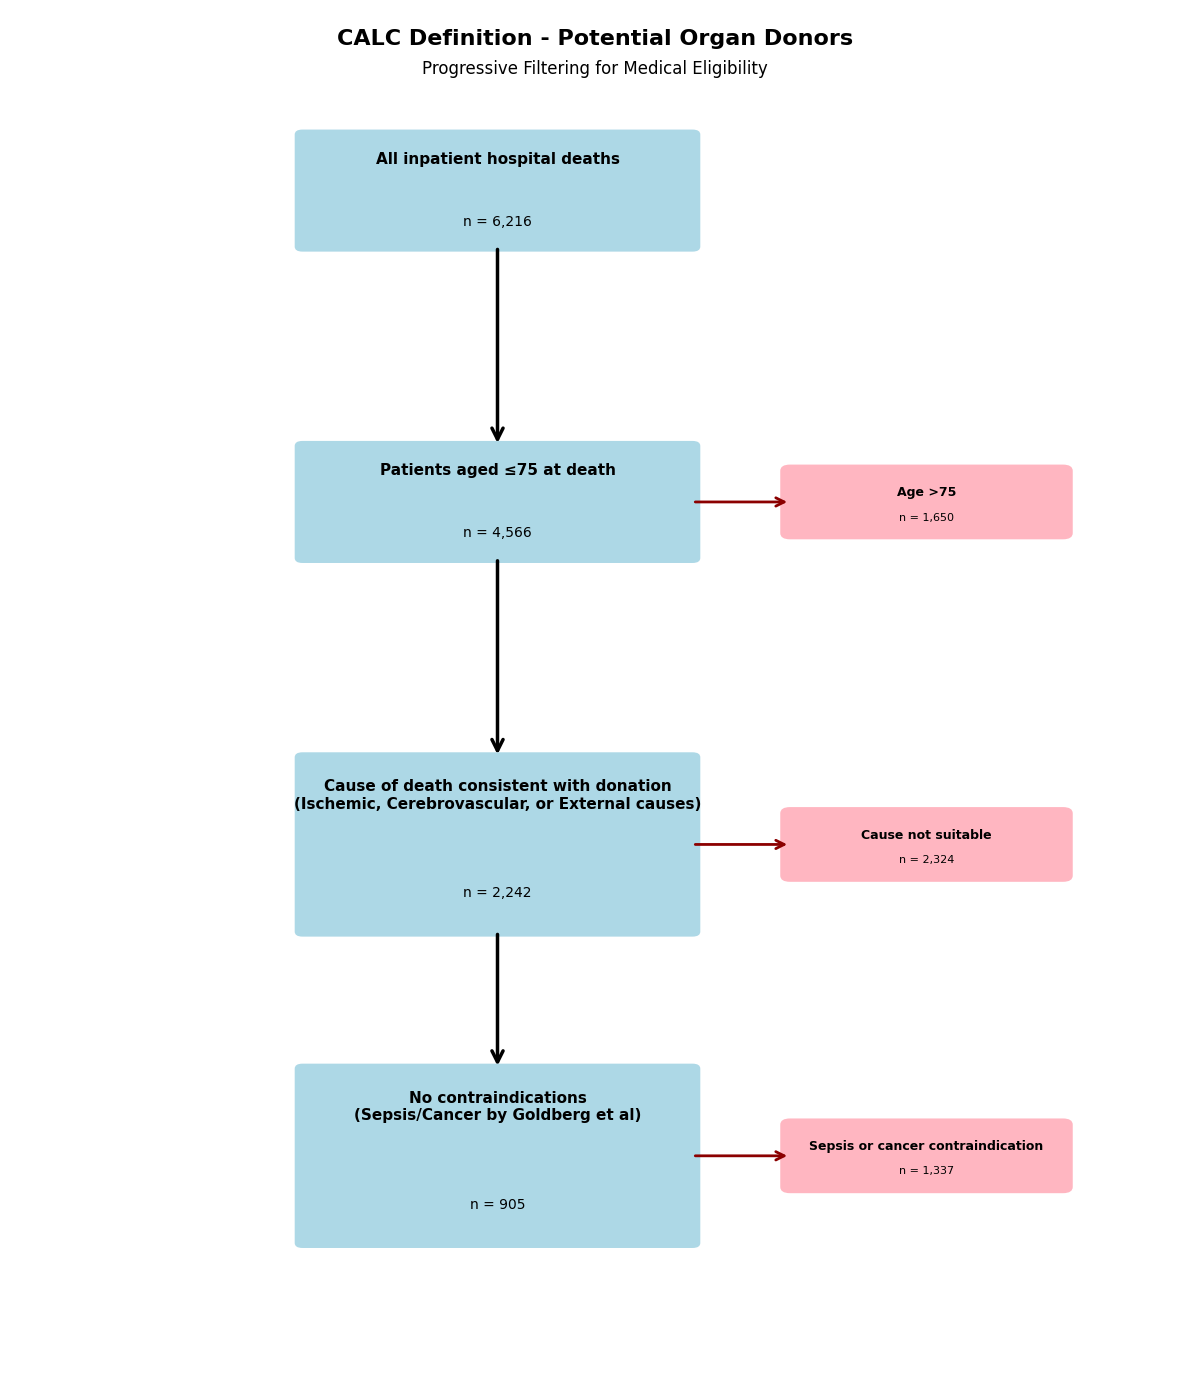

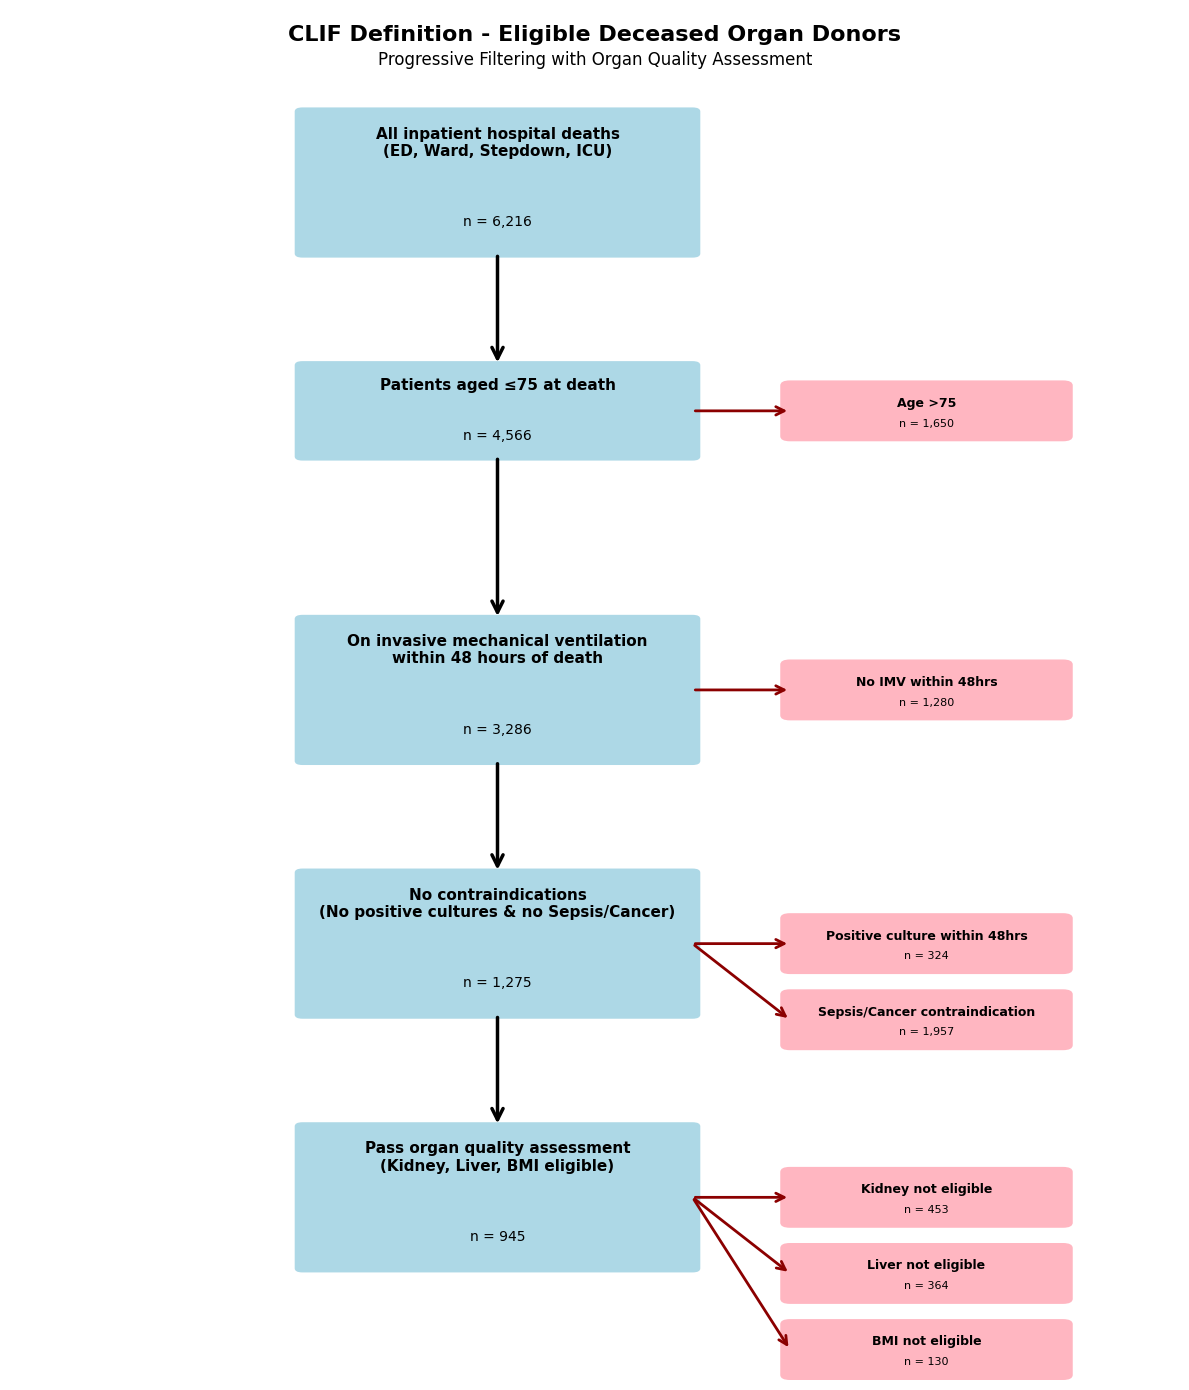

In [50]:
import importlib
import utils.strobe_diagram
importlib.reload(utils.strobe_diagram)

from utils.strobe_diagram import create_strobe_diagrams_for_cohorts
results = create_strobe_diagrams_for_cohorts(
      final_cohort_df,
      output_dir='../output/final',
      save_figures=True,
      save_csvs=True
  )

# Access results
calc_stages = results['CALC']['stages']
clif_stages = results['CLIF']['stages']